In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm


df = pd.read_csv('/content/polynomial_regression.csv')
X = df[['x']]
y = df['y']
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


FileNotFoundError: [Errno 2] No such file or directory: '/content/polynomial_regression.csv'

In [ ]:
n_samples = 30
sample_size = 20
max_degree = 10

train_scores = []
test_scores = []
mse_train_errors = []
mse_test_errors = []



for i in range(n_samples):
    # print(f" Sample {i + 1}/{n_samples}")

    train_sample = pd.concat([X_train_full, y_train_full], axis=1).sample(n=sample_size, random_state=i)
    X_sample = train_sample[['x']]
    y_sample = train_sample['y']

    sample_train_scores = []
    sample_test_scores = []
    sample_train_mse = []
    sample_test_mse = []

    for degree in range(1, max_degree + 1):
        poly = PolynomialFeatures(degree)
        X_sample_poly = poly.fit_transform(X_sample)
        X_test_poly = poly.transform(X_test)

        X_sample_poly_sm = sm.add_constant(X_sample_poly)
        X_test_poly_sm = sm.add_constant(X_test_poly)

        model = sm.OLS(y_sample, X_sample_poly_sm).fit()
        y_sample_pred = model.predict(X_sample_poly_sm)
        y_test_pred = model.predict(X_test_poly_sm)

        mse_train = mean_squared_error(y_sample, y_sample_pred)
        mse_test = mean_squared_error(y_test, y_test_pred)
        r2_train = r2_score(y_sample, y_sample_pred)
        r2_test = r2_score(y_test, y_test_pred)


        print(f"  Degree {degree}: R² Train = {r2_train:.4f}, R² Test = {r2_test:.4f}, MSE Train = {mse_train:.2f}, MSE Test = {mse_test:.2f}")

        sample_train_mse.append(mse_train)
        sample_test_mse.append(mse_test)
        sample_train_scores.append(r2_train)
        sample_test_scores.append(r2_test)

    mse_train_errors.append(sample_train_mse)
    mse_test_errors.append(sample_test_mse)
    train_scores.append(sample_train_scores)
    test_scores.append(sample_test_scores)

    print("-" * 60)


  Degree 1: R² Train = 0.9289, R² Test = 0.5058, MSE Train = 42948.50, MSE Test = 1326228.20
  Degree 2: R² Train = 0.9339, R² Test = 0.5743, MSE Train = 39922.62, MSE Test = 1142496.45
  Degree 3: R² Train = 0.9643, R² Test = 0.6672, MSE Train = 21550.56, MSE Test = 893151.26
  Degree 4: R² Train = 0.9841, R² Test = -1.2709, MSE Train = 9615.96, MSE Test = 6094263.23
  Degree 5: R² Train = 0.9893, R² Test = 0.7860, MSE Train = 6444.07, MSE Test = 574225.00
  Degree 6: R² Train = 0.9898, R² Test = -2.3536, MSE Train = 6184.19, MSE Test = 8999825.13
  Degree 7: R² Train = 0.9906, R² Test = -282.4819, MSE Train = 5687.85, MSE Test = 760770499.61
  Degree 8: R² Train = 0.9909, R² Test = -2444.6235, MSE Train = 5500.80, MSE Test = 6563233631.18
  Degree 9: R² Train = 0.9910, R² Test = -32754.0322, MSE Train = 5414.20, MSE Test = 87903527699.47
  Degree 10: R² Train = 0.9921, R² Test = -15894698.9391, MSE Train = 4771.45, MSE Test = 42656047063677.34
----------------------------------------

Generating violin plot: Test Error (MSE) vs Polynomial Degree...


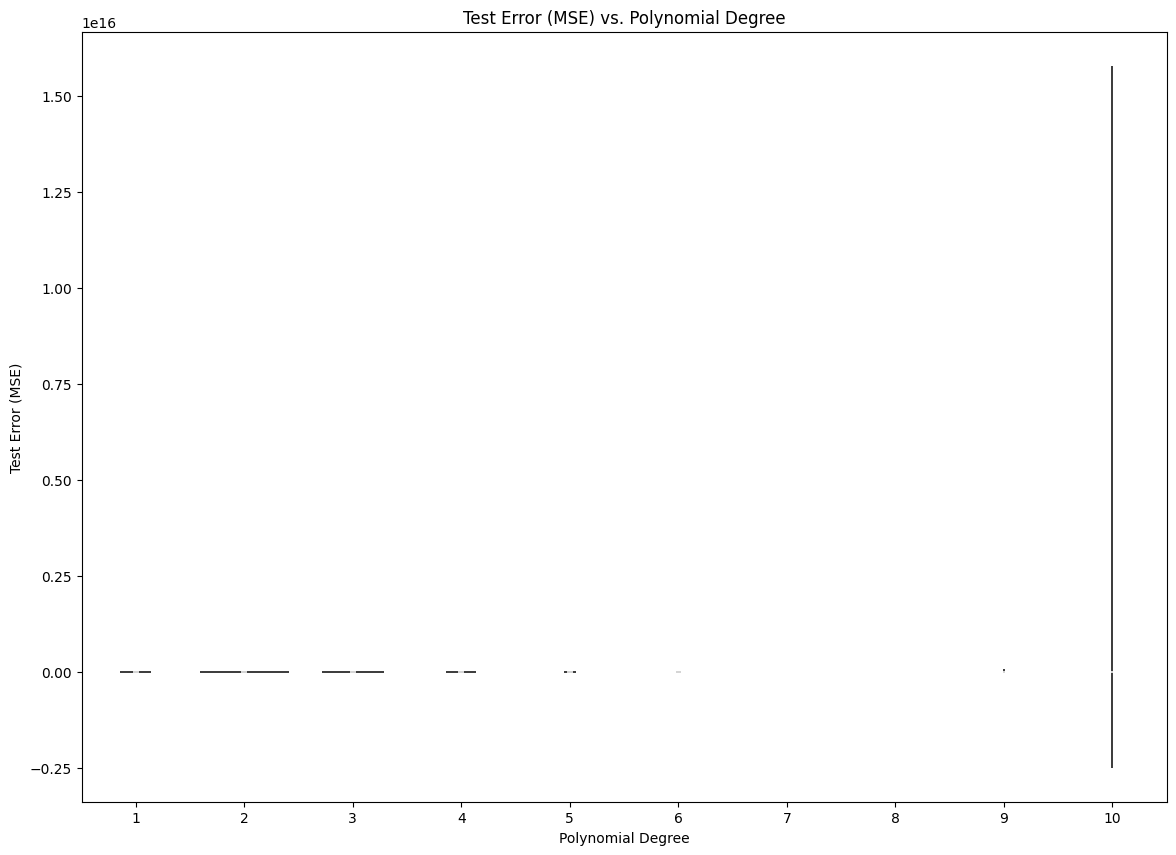

In [ ]:
print("Generating violin plot: Test Error (MSE) vs Polynomial Degree...")
testMSE_degree = {'Degree': [], 'Test Error (MSE)': []}
for sample in mse_test_errors:
    for degree, mse in zip(range(1, max_degree + 1), sample):
        testMSE_degree['Degree'].append(degree)
        testMSE_degree['Test Error (MSE)'].append(mse)

df_violin = pd.DataFrame(testMSE_degree)
plt.figure(figsize=(14, 10))
sns.violinplot(x='Degree', y='Test Error (MSE)', data=df_violin)
plt.title('Test Error (MSE) vs. Polynomial Degree')
plt.xlabel('Polynomial Degree')
plt.ylabel('Test Error (MSE)')
plt.show()


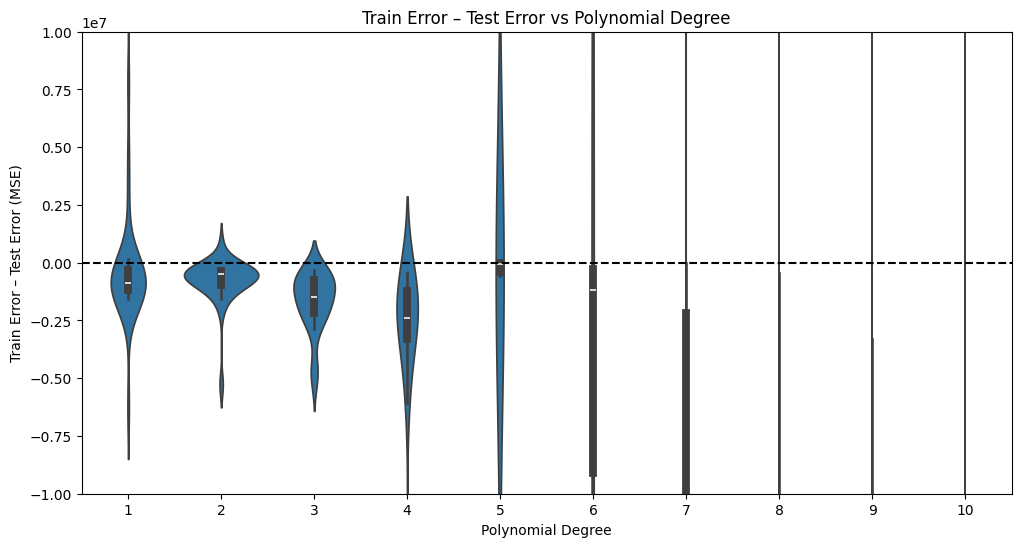

In [ ]:

diff_data = {'Degree': [], 'Train - Test Error': []}
for train_sample, test_sample in zip(mse_train_errors, mse_test_errors):
    for degree, (train_e, test_e) in zip(range(1, max_degree + 1), zip(train_sample, test_sample)):
        diff_data['Degree'].append(degree)
        diff_data['Train - Test Error'].append(train_e - test_e)

df_diff = pd.DataFrame(diff_data)
plt.figure(figsize=(12, 6))
sns.violinplot(x='Degree', y='Train - Test Error', data=df_diff)
plt.axhline(0, linestyle='--', color='black')
plt.title('Train Error – Test Error vs Polynomial Degree')
plt.xlabel('Polynomial Degree')
plt.ylabel('Train Error – Test Error (MSE)')
plt.ylim(-1e7, 1e7)
plt.show()


In [ ]:

sample = pd.concat([X_train_full, y_train_full], axis=1).sample(n=20, random_state=42)
X_sample = sample[['x']]
y_sample = sample['y']

kf = KFold(n_splits=5, shuffle=True, random_state=42)
best_degree = 0
best_r2 = -float('inf')

for degree in range(1, max_degree + 1):
    r2s = []
    poly = PolynomialFeatures(degree)
    X_poly = poly.fit_transform(X_sample)

    for train_index, val_index in kf.split(X_sample):
        X_train, X_val = X_poly[train_index], X_poly[val_index]
        y_train, y_val = y_sample.iloc[train_index], y_sample.iloc[val_index]

        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        r2s.append(r2_score(y_val, y_pred))

    avg_score = np.mean(r2s)
    print(f"Degree {degree}: Average CV R² = {avg_score:.5f}")
    if avg_score > best_r2:
        best_r2 = avg_score
        best_degree = degree

print(f" Best degree found: {best_degree} with CV R² = {best_r2:.5f}")

# Train model on 20 sample points using best degree and test
poly = PolynomialFeatures(best_degree)
X_poly_sample = poly.fit_transform(X_sample)
X_poly_test = poly.transform(X_test)

model = LinearRegression()
model.fit(X_poly_sample, y_sample)
y_test_pred = model.predict(X_poly_test)

test_r2 = r2_score(y_test, y_test_pred)
print(f" Test R² for best degree {best_degree}: {test_r2:.5f}")


Degree 1: Average CV R² = 0.70414
Degree 2: Average CV R² = 0.81634
Degree 3: Average CV R² = 0.94824
Degree 4: Average CV R² = 0.89185
Degree 5: Average CV R² = 0.98545
Degree 6: Average CV R² = 0.96737
Degree 7: Average CV R² = 0.97316
Degree 8: Average CV R² = -0.00262
Degree 9: Average CV R² = 0.67356
Degree 10: Average CV R² = -406.80025
 Best degree found: 5 with CV R² = 0.98545
 Test R² for best degree 5: 0.96454


In [ ]:


best_r2 = -float('inf')
best_degree = 0
best_alpha = 0
best_penalty = None

for degree in range(1, max_degree + 1):
    for penalty in ['l1', 'l2']:
        for alpha in [0.001, 0.01, 0.1, 1, 10]:
            r2s = []
            poly = PolynomialFeatures(degree)
            X_train_poly = poly.fit_transform(X_train_full)

            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train_poly)

            kf = KFold(n_splits=10, shuffle=True, random_state=42)
            for train_index, val_index in kf.split(X_train_scaled):
                X_train = X_train_scaled[train_index]
                X_val = X_train_scaled[val_index]
                y_train = y_train_full.iloc[train_index]
                y_val = y_train_full.iloc[val_index]

                if penalty == 'l1':
                    model = Lasso(alpha=alpha, max_iter=100000)
                else:
                    model = Ridge(alpha=alpha)

                model.fit(X_train, y_train)
                y_pred = model.predict(X_val)
                r2s.append(r2_score(y_val, y_pred))

            avg_r2 = np.mean(r2s)
            print(f"Degree {degree}, Penalty {penalty}, Alpha {alpha} → CV R² = {avg_r2:.5f}")
            if avg_r2 > best_r2:
                best_r2 = avg_r2
                best_degree = degree
                best_alpha = alpha
                best_penalty = penalty

# print(f" Best regularized model → Degree = {best_degree}, Penalty = {best_penalty}, Alpha = {best_alpha}, CV R² = {best_r2:.5f}")

# Final model on full train set
poly = PolynomialFeatures(best_degree)
X_train_poly = poly.fit_transform(X_train_full)
X_test_poly = poly.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_poly)
X_test_scaled = scaler.transform(X_test_poly)

if best_penalty == 'l1':
    model = Lasso(alpha=best_alpha, max_iter=100000)
else:
    model = Ridge(alpha=best_alpha)

model.fit(X_train_scaled, y_train_full)
y_test_pred = model.predict(X_test_scaled)

final_r2 = r2_score(y_test, y_test_pred)
print(f" Final Test R² (Regularized Model): {final_r2:.5f}")


Degree 1, Penalty l1, Alpha 0.001 → CV R² = 0.52502
Degree 1, Penalty l1, Alpha 0.01 → CV R² = 0.52502
Degree 1, Penalty l1, Alpha 0.1 → CV R² = 0.52502
Degree 1, Penalty l1, Alpha 1 → CV R² = 0.52500
Degree 1, Penalty l1, Alpha 10 → CV R² = 0.52481
Degree 1, Penalty l2, Alpha 0.001 → CV R² = 0.52502
Degree 1, Penalty l2, Alpha 0.01 → CV R² = 0.52502
Degree 1, Penalty l2, Alpha 0.1 → CV R² = 0.52502
Degree 1, Penalty l2, Alpha 1 → CV R² = 0.52502
Degree 1, Penalty l2, Alpha 10 → CV R² = 0.52499
Degree 2, Penalty l1, Alpha 0.001 → CV R² = 0.72138
Degree 2, Penalty l1, Alpha 0.01 → CV R² = 0.72138
Degree 2, Penalty l1, Alpha 0.1 → CV R² = 0.72138
Degree 2, Penalty l1, Alpha 1 → CV R² = 0.72141
Degree 2, Penalty l1, Alpha 10 → CV R² = 0.72157
Degree 2, Penalty l2, Alpha 0.001 → CV R² = 0.72138
Degree 2, Penalty l2, Alpha 0.01 → CV R² = 0.72138
Degree 2, Penalty l2, Alpha 0.1 → CV R² = 0.72138
Degree 2, Penalty l2, Alpha 1 → CV R² = 0.72138
Degree 2, Penalty l2, Alpha 10 → CV R² = 0.72141
